In [ ]:
%pip install opencv-python-headless==4.9.0.80
%pip install torch
%pip install torchvision
%pip install torchsummary 

In [29]:
import cv2
import torch
import torchvision
import sklearn.svm

import torch
from torch import cuda
from torchvision import transforms, datasets, models
from pathlib import Path
from timeit import default_timer as timer
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


from torchsummary import summary
print('import successful')

import successful


In [30]:
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

BASE_PATH = Path('/home/jovyan/work/data/out/KDEF-AKDEF')
IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))

TRAIN = 'train'
VAL = 'val'
TEST = 'test'

batch_size = 8

print(Path.cwd())

Train on gpu: False
/home/jovyan


In [31]:
# prepare data for feature extraction
feature_extraction_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

image_datasets = {
    x: datasets.ImageFolder(
        root=(BASE_PATH / x),
        transform=feature_extraction_transform
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = { x : len(image_datasets[x]) for x in [TRAIN, VAL, TEST] }
class_names = image_datasets[TRAIN].classes
n_classes = len(class_names)
n_images = 0
for x in [TRAIN, VAL, TEST]:
    print(f"[INFO] Number of images in {x} set ...{dataset_sizes[x]}")
    n_images += dataset_sizes[x]

print(f"[INFO] Total number of images ...{n_images}")
print("[INFO] Number of classes: ", n_classes)
print("[INFO] Classes: ", image_datasets[TRAIN].classes)

[INFO] Number of images in train set ...2938
[INFO] Number of images in val set ...980
[INFO] Number of images in test set ...980
[INFO] Total number of images ...4898
[INFO] Number of classes:  7
[INFO] Classes:  ['Afraid', 'Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Surprised']


In [32]:
# prepare vgg16 for feature extraction
conv_base = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
features = list(conv_base.classifier)[:-3]
conv_base.classifier = nn.Sequential(*features)
summary(conv_base, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 224, 224]           1,792
              ReLU-2          [8, 64, 224, 224]               0
            Conv2d-3          [8, 64, 224, 224]          36,928
              ReLU-4          [8, 64, 224, 224]               0
         MaxPool2d-5          [8, 64, 112, 112]               0
            Conv2d-6         [8, 128, 112, 112]          73,856
              ReLU-7         [8, 128, 112, 112]               0
            Conv2d-8         [8, 128, 112, 112]         147,584
              ReLU-9         [8, 128, 112, 112]               0
        MaxPool2d-10           [8, 128, 56, 56]               0
           Conv2d-11           [8, 256, 56, 56]         295,168
             ReLU-12           [8, 256, 56, 56]               0
           Conv2d-13           [8, 256, 56, 56]         590,080
             ReLU-14           [8, 256,

In [33]:
class_to_idx = image_datasets[TRAIN].class_to_idx
idx_to_class = { idx: class_ for class_, idx in class_to_idx.items() }

print(class_to_idx)
print(idx_to_class)

{'Afraid': 0, 'Angry': 1, 'Disgusted': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprised': 6}
{0: 'Afraid', 1: 'Angry', 2: 'Disgusted', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprised'}


In [35]:
def extract_features(dataloaders):

    features = torch.zeros(0, 4096)
    labels = torch.zeros(0, dtype=torch.long)
    i = 0

    for phase in ([TRAIN, TEST, VAL]):

        
        for inputs_batch, labels_batch in tqdm(dataloaders[phase]):
            i += 1
            with torch.no_grad():
                features_batch = conv_base(inputs_batch)
                features = torch.cat((features, features_batch))

            labels = torch.cat((labels, labels_batch))
        
            if i >= 50:
                return features, labels
    

In [12]:
features, labels = extract_features(dataloaders=dataloaders, batch_size=batch_size)

 13%|█████████████▊                                                                                          | 49/368 [03:44<24:20,  4.58s/it]


In [13]:
print(features.shape)
print(labels.shape)

torch.Size([400, 4096])
torch.Size([400])


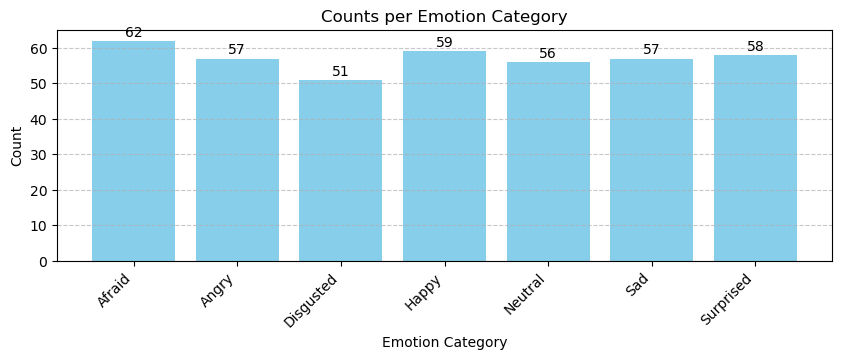

In [48]:
category_counts = {}
for value in labels:
    category_counts[class_names[value.item()]] = category_counts.get(class_names[value.item()], 0) + 1

sorted_counts = sorted(category_counts.items(), key=lambda x: x[0])
categories, counts = zip(*sorted_counts)

plt.figure(figsize=(10, 3))
bars = plt.bar(categories, counts, color='skyblue')
plt.xlabel('Emotion Category')
plt.ylabel('Count')
plt.title('Counts per Emotion Category')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, count, ha='center', va='bottom')

plt.show()


### SVM Init

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)

In [16]:
print("[INFO] Number of images used in training ...", x_train.shape[0])
print("[INFO] Number of images used in testing ...", x_test.shape[0])

classifier = SVC()
parameters = {'gamma': [0.1, 0.01, 0.001], 'C': [1, 10, 100, 1000]}

[INFO] Number of images used in training ... 320
[INFO] Number of images used in testing ... 80


In [17]:
grid_search = GridSearchCV(classifier, parameters, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_estimator = grid_search.best_estimator_
print("[INFO] Best params ...", grid_search.best_params_)

[INFO] Best params ... {'C': 10, 'gamma': 0.001}


In [18]:
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        y_prediction = clf.predict(x_train)
        clf_report = classification_report(y_train, y_prediction)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_prediction)}\n")
        
    elif train==False:
        y_prediction = clf.predict(x_test)
        clf_report = classification_report(y_test, y_prediction)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_prediction)}\n")

In [20]:
import pickle 

pickle.dump(best_estimator, open('/home/jovyan/work/model.p', 'wb'))

print_score(best_estimator, x_train, y_train, x_test, y_test, train=True)
print_score(best_estimator, x_train, y_train, x_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        45
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        45
           5       1.00      1.00      1.00        46
           6       1.00      1.00      1.00        46

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

_______________________________________________
Confusion Matrix: 
 [[50  0  0  0  0  0  0]
 [ 0 45  0  0  0  0  0]
 [ 0  0 41  0  0  0  0]
 [ 0  0  0 47  0  0  0]
 [ 0  0  0  0 45  0  0]
 [ 0  0  0  0  0 46  0]
 [ 0  0  0  0  0  0 46]]

Test Result:
Accuracy Score: 21.25%
____________________

### K-fold cross-validation

In [21]:
n_splits_values = [3, 5, 10]

for n_splits in n_splits_values:
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    scores = cross_val_score(best_estimator, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
    print(f"{n_splits}-Fold CV: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")

3-Fold CV: 0.19 accuracy with a standard deviation of 0.02
5-Fold CV: 0.20 accuracy with a standard deviation of 0.04
10-Fold CV: 0.20 accuracy with a standard deviation of 0.07
